## Question 3: Cultural Arts Organizations course types and number of instructional hours per year correlation with ELA and Math performance

Author: Thomas

Updates:
* Last updated on March 26, 2020
* Updated on March 25, 2020
* Updated on March 24, 2020
* Updated on March 23, 2020
* Updated on March 21, 2020

**Hypothesis**: If art programs provided by Cultural Arts Organizations affect student performance, then schools with stronger indicators of instructional hours will have significantly different math and ela state test scores than schools with weaker indicators of instructional hours.

**Null hypothesis**: If art programs provided by Cultural Arts Organizations do not affect student performance, then schools with stronger indicators of instructional hours will not have significantly different math and ELA state test scores than schools with weaker indicators of instructional hours.

**Indicators of instructional hours** will be: (a) number of art course types and (b) self-report of instructional hours. 

**Math/ELA performance** will be measured by pass rate (proportion of students earning a score of 3 or 4).

## Data

### School Test Results Data
2013-2019 School Test Results Page
https://infohub.nyced.org/reports/academics/test-results

2013-2019 ELA Test Results: 
https://infohub.nyced.org/docs/default-source/default-document-library/school-ela-results-2013-2019-(public).xlsx

2013-2019 Math Test Results: 
https://infohub.nyced.org/docs/default-source/default-document-library/school-math-results-2013-2019-(public).xlsx

### Arts Survey Data
2016-2017 Arts Survey Data
https://data.cityofnewyork.us/Education/2016-2017-Arts-Survey-data/f33j-ecpr

2017-2018 Arts Survey Data
https://data.cityofnewyork.us/Education/2017-2018-Arts-Data-Report/d9fr-a56v

2018-2019 Arts Data Survey
https://data.cityofnewyork.us/Education/2018-2019-Arts-Data-Survey/5cxm-c27f

In [1]:
# import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import json


## Dataset 1: Math and ELA Tests Data

In [2]:
# CSV Files
math_results = 'data/2013-2019_school_math_results.csv'
ela_results = 'data/2013-2019_school_ela_results.csv'

In [216]:
# read csv file into dataframe
math_df = pd.read_csv(math_results, encoding='utf-8', low_memory=False)

# clean up math dataframe

keep_cols = ['DBN','Year','Grade','Number Tested','# Level 3+4', f'% Level 3+4']
keep_grades = ['3', '4','5','6']

# drop unneeded columns
math_df = math_df.drop(labels='Unnamed: 0', axis=1)[math_df.Year >= 2017].reset_index().drop(labels='index', axis=1)[keep_cols]
# remove all rows matching `All Grades` grade
math_df = math_df[ math_df.Grade == 'All Grades' ]
# set `Grade` to int type
#math_df.Grade = math_df.Grade.astype(int)
# keep only grades from 3 to 6
#math_df = math_df[ (math_df.Grade >= 3) & (math_df.Grade <= 6) ]
# add test column
math_df['Test'] = 'Math'

math_df.drop(labels='Grade', axis=1, inplace=True)

print(math_df.shape)
math_df.head(1)


(3314, 6)


,DBN,Year,Number Tested,# Level 3+4,% Level 3+4,Test
9,01M015,2017,69,31,44.92753601,Math


In [217]:
# read csv file into dataframe
ela_df = pd.read_csv(ela_results, encoding='utf-8', low_memory=False)

# clean up ela dataframe

# drop unneeded columns
ela_df = ela_df.drop(labels='Unnamed: 0', axis=1)[ela_df.Year >= 2017].reset_index().drop(labels='index', axis=1)[keep_cols]
# remove all rows matching `All Grades` grade
ela_df = ela_df[ ela_df.Grade == 'All Grades' ]
# set `Grade` to int type
#ela_df.Grade = ela_df.Grade.astype(int)
# keep only grades from 3 to 6
#ela_df = ela_df[ (ela_df.Grade >= 3) & (ela_df.Grade <= 6) ]
# add test column
ela_df['Test'] = 'ELA'

ela_df.drop(labels='Grade', axis=1, inplace=True)

print(ela_df.shape)
ela_df.head(1)

(3315, 6)


,DBN,Year,Number Tested,# Level 3+4,% Level 3+4,Test
9,01M015,2017,67,24,35.82089615,ELA


In [218]:
# concatenate both dataframes into one
tests_df = pd.concat([math_df, ela_df])

# clean up dataframe

# cast values to numeric types and force non-numeric to NaN
tests_df['# Level 3+4'] = pd.to_numeric(tests_df['# Level 3+4'], errors='coerce')
tests_df['% Level 3+4'] = pd.to_numeric(tests_df['% Level 3+4'], errors='coerce')

# drop any rows with any NaN values
tests_df = tests_df.dropna(how='any')

# cast to integer
tests_df['# Level 3+4'] = tests_df['# Level 3+4'].astype(int)

# reset index and drop extra column
tests_df = tests_df.reset_index().drop(labels='index', axis=1)

print(tests_df.shape)
tests_df.head(1)

(6629, 6)


,DBN,Year,Number Tested,# Level 3+4,% Level 3+4,Test
0,01M015,2017,69,31,44.927536,Math


## Dataset 2: Art Surveys Data

In [220]:
# CSV files
arts_2017 = 'data/2016-2017_Arts_Survey_Data.csv'
arts_2018 = 'data/2017-2018_Arts_Survey_Data.csv'
arts_2019 = 'data/2018-2019_Arts_Survey_Data.csv'

arts_csv = {
    2017: arts_2017,
    2018: arts_2018,
    2019: arts_2019
}

### Load and clean data for 2017-2019 Arts Surveys

In [226]:
# all grades
grades = {
    'Q15': '3',
    'Q16': '4',
    'Q17': '5',
    'Q19': '6'
}

arts = {
    'Dance': 'R1',
    'Music': 'R2',
    'Theater': 'R3',
    'Visual Arts': 'R4'
}



columns = ['DBN','Year','Dance','Music','Theater','Visual Arts']
arts_df = pd.DataFrame(columns=columns)

for (year, csv) in arts_csv.items():
    df = pd.read_csv(csv, encoding='utf-8', low_memory=False)
    #df = df.rename(columns={ 'Q0_DBN': 'DBN' })
    s_arts = pd.DataFrame()
    s_arts['DBN'] = df['Q0_DBN']
    s_arts['Year'] = year
    
    
    for (art, typ) in arts.items():
        cols = [  col for col in df.columns if all(ele in col for ele in [ typ ]) ]
        s_arts[art] = df[cols].fillna(0).sum(axis=1)

    # concatenate the grade data into the master dataframe
    arts_df = pd.concat([arts_df, s_arts])
    

# reorder columns
arts_df = arts_df[arts_df.columns.tolist()[:-4]+arts_df.columns.tolist()[-4:]]

# reset index to remove duplicate indices and drop extra column
arts_df = arts_df.reset_index().drop(labels='index', axis=1)

# calculate total hours of instructions
arts_df['Hours'] = arts_df[arts_df.columns[-4:]].sum(axis=1)

# calculate count of types of art provided
arts_df['Count'] = arts_df[arts_df.columns[-5:-1]].astype(bool).sum(axis=1)

# cast `Year` and `Grade` as integers
arts_df = arts_df.astype({ 'Year': 'int', 'Count': 'int' })

# check dataframe
print(arts_df.shape)
arts_df.head(2)

(4513, 8)


,DBN,Year,Dance,Music,Theater,Visual Arts,Hours,Count
0,01M015,2017,385.0,262.0,159.0,155.0,961.0,4
1,01M019,2017,801.0,243.0,14.0,194.0,1252.0,4


In [183]:
grades = {
    'Q15': '3',
    'Q16': '4',
    'Q17': '5',
    'Q19': '6'
}

arts = {
    'Dance': 'R1',
    'Music': 'R2',
    'Theater': 'R3',
    'Visual Arts': 'R4'
}


columns = ['DBN','Year','Grade','Dance','Music','Theater','Visual Arts']
arts_df = pd.DataFrame(columns=columns)

for (year, csv) in arts_csv.items():
    df = pd.read_csv(csv, encoding='utf-8', low_memory=False)
    df = df.rename(columns={ 'Q0_DBN': 'DBN' })
    df['Year'] = year
    
    for (question, grade) in grades.items():
        
        grade_df = pd.DataFrame(columns=columns)
        grade_df[['DBN','Year']] = df[['DBN','Year']]
        grade_df['Grade'] = int(grade)
        
        for (art, typ) in arts.items():
            cols = [  col for col in df.columns if all(ele in col for ele in [ question, typ ]) ]
            grade_df[art] = df[cols].fillna(0).sum(axis=1)

        # concatenate the grade data into the master dataframe
        arts_df = pd.concat([arts_df, grade_df])
    

# reorder columns
arts_df = arts_df[arts_df.columns.tolist()[:-4]+arts_df.columns.tolist()[-4:]]

# reset index to remove duplicate indices and drop extra column
arts_df = arts_df.reset_index().drop(labels='index', axis=1)

# calculate total hours of instructions
arts_df['Total_Hrs'] = arts_df[arts_df.columns[-4:]].sum(axis=1)

# calculate count of types of art provided
arts_df['Art_Count'] = arts_df[arts_df.columns[-5:-1]].astype(bool).sum(axis=1)

# cast `Year` and `Grade` as integers
arts_df = arts_df.astype({ 'Year': 'int', 'Grade': 'int', 'Art_Count': 'int' })

# check dataframe
print(arts_df.shape)
arts_df.head(2)

(18052, 9)


,DBN,Year,Grade,Dance,Music,Theater,Visual Arts,Total_Hrs,Art_Count
0,01M015,2017,3,36.0,56.0,10.0,20.0,122.0,4
1,01M019,2017,3,208.0,48.0,0.0,40.0,296.0,3


In [196]:
s2019 = pd.read_csv(arts_2019, encoding='utf-8', low_memory=False)

s2019 = s2019.rename(columns={ 'Q0_DBN': 'DBN'})

s_arts = pd.DataFrame()
s_arts['DBN'] = s2019['DBN']
s_arts['Year'] = 2019

for (art, typ) in arts.items():
    cols = [  col for col in s2019.columns if all(ele in col for ele in [ typ ]) ]
    s_arts[art] = df[cols].fillna(0).sum(axis=1)

# calculate total hours of instructions
s_arts['Hours'] = s_arts[s_arts.columns[-4:]].sum(axis=1)

# calculate count of types of art provided
s_arts['Count'] = s_arts[s_arts.columns[-5:-1]].astype(bool).sum(axis=1)

s_arts.head(2)

,DBN,Year,Dance,Music,Theater,Visual Arts,Hours,Count
0,01M015,2019,169.0,417.0,224.0,222.0,1032.0,4
1,01M019,2019,884.0,775.0,584.0,757.0,3000.0,4


In [227]:
# make sure no duplicate indices exist
from collections import Counter
Counter(arts_df.index.duplicated(keep='first'))

Counter({False: 4513})

In [245]:
# merge test scores with art survey data
#data_df = pd.merge(tests_df, arts_df, how='outer', on=['DBN','Year','Grade'])
schools = pd.merge(tests_df, arts_df, how='outer', on=['DBN','Year'])

# drop any schools with no passing data
schools = data_df.dropna(subset=['% Level 3+4'])

schools[data_df.columns.tolist()[-6:]] = data_df[data_df.columns.tolist()[-6:]].fillna(0)

#data_df = data_df.astype({ 'Number Tested': 'int', '# Level 3+4': 'int', 'Art_Count': 'int' })
schools = data_df.astype({ 'Number Tested': 'int', '# Level 3+4': 'int', 'Count': 'int' })

# check dataframe
print(schools.shape)
schools.head(2)

(6629, 12)


In [12]:
# create new table for the merged data for analysis
scl_cols = data_df.columns.tolist()[3:6]+data_df.columns.tolist()[7:]
schools = pd.DataFrame(columns = scl_cols)

# columns to sum
parse_cols = schools.columns.tolist()[:2]+schools.columns.tolist()[3:]
for col in parse_cols:
    schools[col] = data_df.groupby(['DBN','Year','Test'])[col].sum()

# calculate average overall passing rate
schools['% Level 3+4'] = (schools['# Level 3+4']/schools['Number Tested'])*100

# calculate total number of art instructional hours
schools['Total_Hrs'] = schools[schools.columns[-4:]].sum(axis=1)

# calculate total number of art types offered
schools['Art_Count'] = schools[schools.columns[-6:-2]].astype(bool).sum(axis=1)

# reset table index
schools = schools.reset_index()

print(schools.shape)
#schools[(schools['DBN']=='01M015')].head(6)
schools.head()

(6612, 12)


,DBN,Year,Test,Number Tested,# Level 3+4,% Level 3+4,Dance,Music,Theater,Visual Arts,Total_Hrs,Art_Count
0,01M015,2017,ELA,67,24,35.820896,72.0,112.0,35.0,20.0,304.0,4
1,01M015,2017,Math,69,31,44.927536,72.0,112.0,35.0,20.0,304.0,4
2,01M015,2018,ELA,67,45,67.164179,8.0,150.0,48.0,0.0,261.0,3
3,01M015,2018,Math,67,39,58.208955,8.0,150.0,48.0,0.0,261.0,3
4,01M015,2019,ELA,70,42,60.000000,0.0,180.0,80.0,0.0,346.0,2


In [234]:
# make sure no duplicate indices exist
from collections import Counter
Counter(schools.duplicated(keep='first'))

Counter({False: 6629})

## Explore Data

In [233]:
# Data Summary Table
schools_summary = pd.DataFrame({
                                'Number of Schools': [ 
                                                       len(schools[schools['Test']=='ELA']['DBN'].unique()),
                                                       len(schools[schools['Test']=='Math']['DBN'].unique())
                                                     ],
                                'Test Passing Rate': [ 
                                                       round(schools[schools['Test']=='ELA']['% Level 3+4'].mean(),2),
                                                       round(schools[schools['Test']=='Math']['% Level 3+4'].mean(),2)
                                                     ]
                               }, index= schools['Test'].unique() )

schools_summary

,Number of Schools,Test Passing Rate
Math,1118,43.45
ELA,1118,40.68


In [235]:
schools[ schools['Test']=='ELA'].groupby(['Year'])['DBN'].count()

Year
2017    1093
2018    1104
2019    1118
Name: DBN, dtype: int64

In [236]:
schools[schools['Test']=='Math'].groupby(['Year'])['DBN'].count()

Year
2017    1093
2018    1104
2019    1117
Name: DBN, dtype: int64

In [288]:
# Determine if there are any potential outliers for `Hours`
quartiles    = schools['Hours'].quantile([.25,.5,.75])
lowerq       = quartiles[0.25]
upperq       = quartiles[0.75]
iqr          = upperq-lowerq

print(f"The lower quartile of instructional hours is: {lowerq}")
print(f"The upper quartile of instructional hours is: {upperq}")
print(f"The interquartile range of instructional hours is: {iqr}")
print(f"The the median of instructional hours is: {quartiles[0.5]} ")
print()
lower_bound  = lowerq - (1.5*iqr)
upper_bound  = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_cond = (schools['Hours'] < lower_bound) | (schools['Hours'] > upper_bound)
schools = schools.loc[~outlier_cond]
print()
print(schools.shape)
schools.head(3)

The lower quartile of instructional hours is: 133.0
The upper quartile of instructional hours is: 720.0
The interquartile range of instructional hours is: 587.0
The the median of instructional hours is: 355.0 

Values below -747.5 could be outliers.
Values above 1600.5 could be outliers.

(5549, 12)


,DBN,Year,Number Tested,# Level 3+4,% Level 3+4,Test,Dance,Music,Theater,Visual Arts,Hours,Count
0,01M015,2017,69,31,44.927536,Math,385.0,262.0,159.0,155.0,961.0,4
1,01M015,2017,67,24,35.820896,ELA,385.0,262.0,159.0,155.0,961.0,4
2,01M015,2018,67,39,58.208954,Math,121.0,347.0,242.0,47.0,757.0,4


The r-squared value is: 0.04


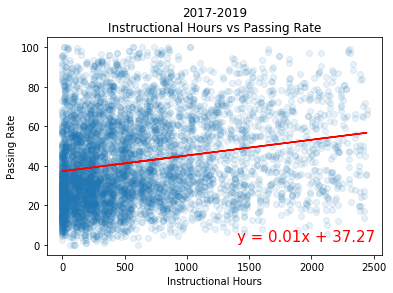

In [282]:
# perform a linear regression 
total_hrs  = schools['Hours']
pass_rate  = schools['% Level 3+4']

slope, intercept, r_value, p_value, stderr  = stats.linregress(total_hrs, pass_rate)
x           = total_hrs
y           = slope * x + intercept
rsq_value   = round(r_value**2,2)

plt.scatter(total_hrs, pass_rate, alpha = .1)

plt.title('2017-2019\nInstructional Hours vs Passing Rate')
plt.xlabel('Instructional Hours')
plt.ylabel(f'Passing Rate')

plt.plot(x, y, color='r')
line_eq     = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq, (1400,2), fontsize = 15, color="r")


print(f"The r-squared value is: {rsq_value}")


plt.show()

In [243]:
# summary of the number of schools that reported instructional hours
# grouped by year and number of art courses reported

years  = schools['Year'].unique()
counts = sorted(schools['Count'].unique())
arts   = ['Dance', 'Music', 'Theater', 'Visual Arts']  

idx1 = []
idx2 = []

for year in years:
    for count in counts:
        idx1.append(year)
        idx2.append(count)

hours_df = pd.DataFrame(index=[np.array(idx1),np.array(idx2)] )

for art in arts:
    temp = schools[(schools[art] == 0)&(schools['Count'] == 0) ].groupby(['Year','Count'])['DBN'].nunique()
    hours_df[art] = temp.append(schools[schools[art] > 0 ].groupby(['Year','Count'])['DBN'].nunique())

hours_df['Number of Schools'] = schools.groupby(['Year','Count'])['DBN'].nunique()
  
hours_df

TypeError: tuple indices must be integers or slices, not str

In [110]:
# extract the data by test
pass_rate  = schools[schools['Art_Count'] == 0]
total_hrs  = schools[schools['Art_Count'] > 0].merge(pass_rate, how='inner', on=['Year'], suffixes=('_NA', '_HA'))
#total_hrs = total_hrs.dropna('% Level 3+4_HA')


print(total_hrs.shape)
total_hrs.head(1)

(2487456, 23)


,DBN_NA,Year,Test_NA,Number Tested_NA,# Level 3+4_NA,% Level 3+4_NA,Dance_NA,Music_NA,Theater_NA,Visual Arts_NA,...,Test_HA,Number Tested_HA,# Level 3+4_HA,% Level 3+4_HA,Dance_HA,Music_HA,Theater_HA,Visual Arts_HA,Total_Hrs_HA,Art_Count_HA
0,01M015,2017,ELA,67,24,35.820896,72.0,112.0,35.0,20.0,...,ELA,49,10,20.408163,0.0,0.0,0.0,0.0,0.0,0


The r-squared value is: 0.01


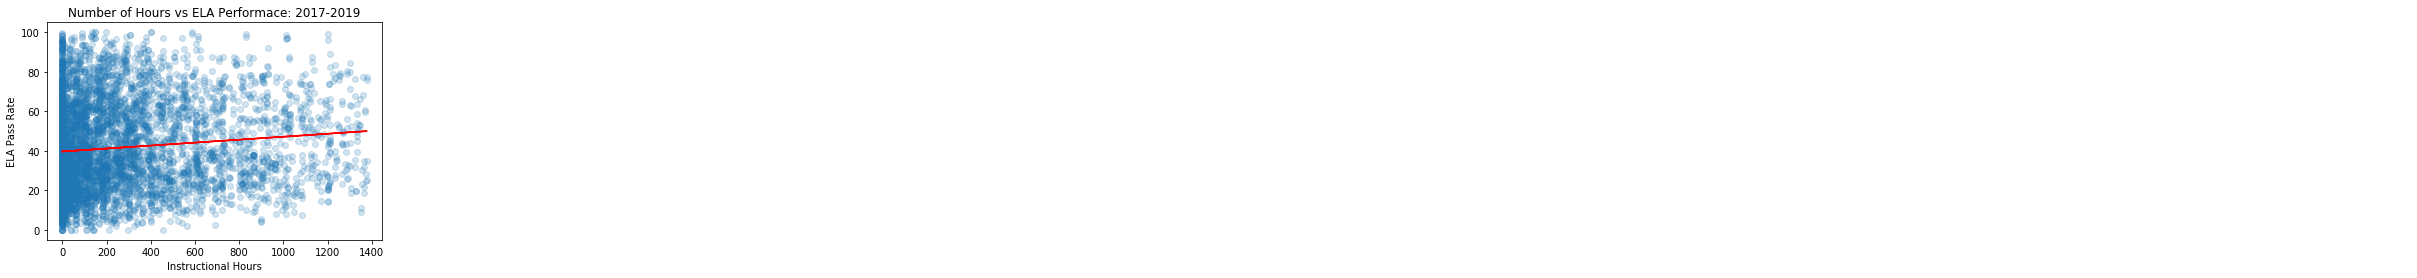

In [120]:
# extract the data by test

cond = (schools['Total_Hrs'] <= 1393)
total_hrs  = schools[cond]['Total_Hrs']
pass_rate  = schools[cond]['% Level 3+4']

slope, intercept, r_value, p_value, stderr  = stats.linregress(total_hrs, pass_rate)
x           = total_hrs
y           = slope * x + intercept
rsq_value   = round(r_value**2,2)

plt.scatter(total_hrs, pass_rate, alpha = .2)

plt.title(f'Number of Hours vs {test} Performace: 2017-2019')
plt.xlabel('Instructional Hours')
plt.ylabel(f'{test} Pass Rate')

plt.plot(x, y, color='r')
line_eq     = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq, (10000,80), fontsize = 15, color="r")


print(f"The r-squared value is: {rsq_value}")


plt.show()

The r-squared value is: 0.01


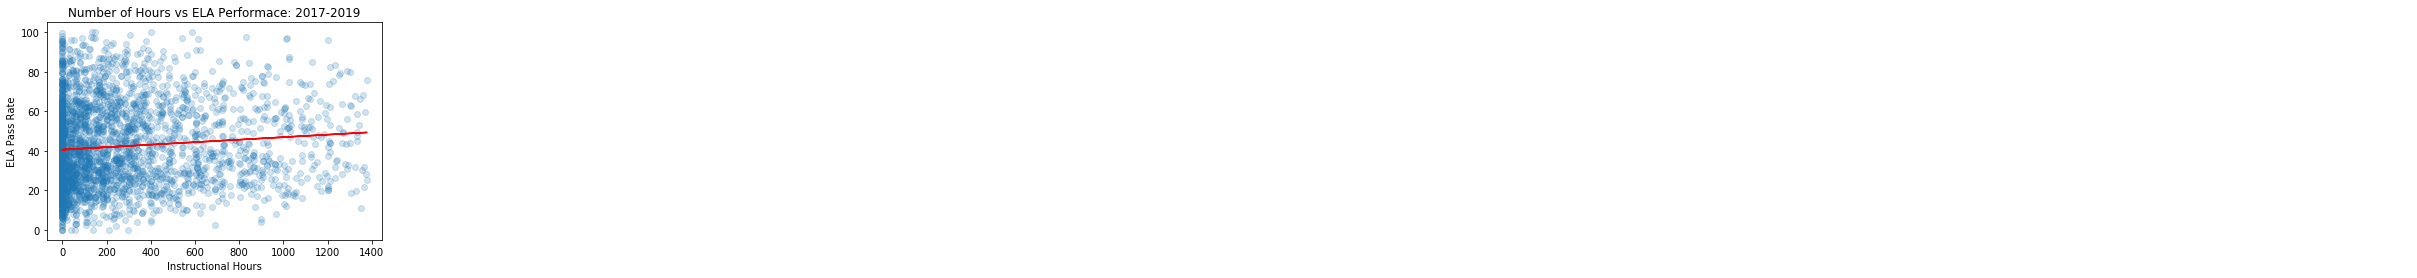

In [119]:
# extract the data by test
test = 'ELA'
cond = ( (schools['Test']==test) & (schools['Total_Hrs'] <= 1393) )
total_hrs  = schools[cond]['Total_Hrs']
pass_rate  = schools[cond]['% Level 3+4']

slope, intercept, r_value, p_value, stderr  = stats.linregress(total_hrs, pass_rate)
x           = total_hrs
y           = slope * x + intercept
rsq_value   = round(r_value**2,2)

plt.scatter(total_hrs, pass_rate, alpha = .2)

plt.title(f'Number of Hours vs {test} Performace: 2017-2019')
plt.xlabel('Instructional Hours')
plt.ylabel(f'{test} Pass Rate')

plt.plot(x, y, color='r')
line_eq     = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq, (10000,80), fontsize = 15, color="r")


print(f"The r-squared value is: {rsq_value}")


plt.show()

The r-squared value is: 0.01


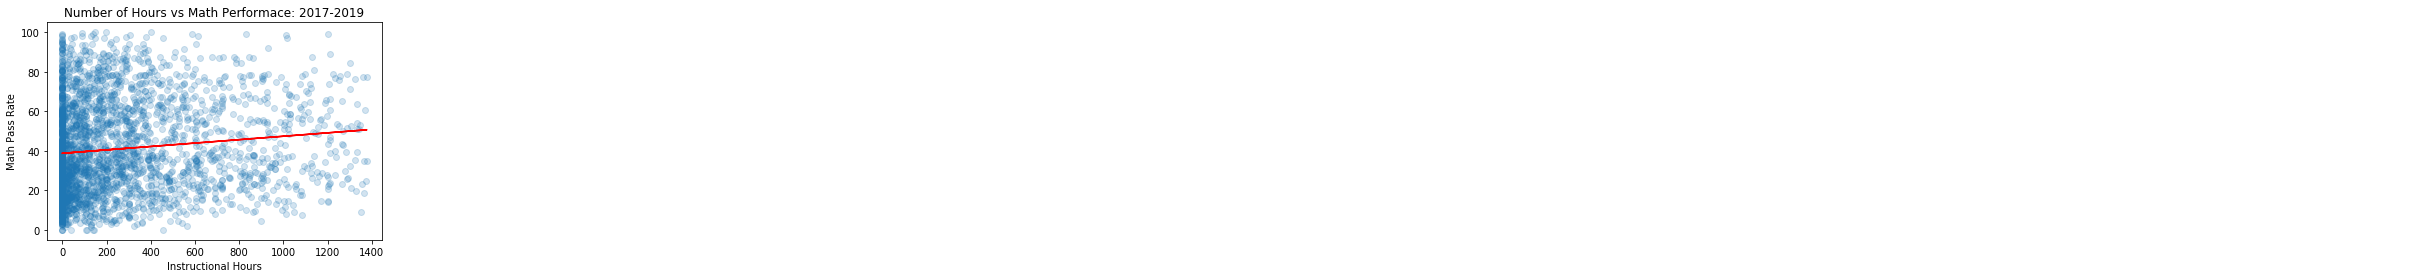

In [118]:
# extract the data by test
test = 'Math'
cond = ( (schools['Test']==test) & (schools['Total_Hrs'] <= 1393) )
total_hrs  = schools[cond]['Total_Hrs']
pass_rate  = schools[cond]['% Level 3+4']

slope, intercept, r_value, p_value, stderr  = stats.linregress(total_hrs, pass_rate)
x           = total_hrs
y           = slope * x + intercept
rsq_value   = round(r_value**2,2)

plt.scatter(total_hrs, pass_rate, alpha = .2)

plt.title(f'Number of Hours vs {test} Performace: 2017-2019')
plt.xlabel('Instructional Hours')
plt.ylabel(f'{test} Pass Rate')

plt.plot(x, y, color='r')
line_eq     = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq, (10000,80), fontsize = 15, color="r")


print(f"The r-squared value is: {rsq_value}")


plt.show()

In [155]:
schools.columns.tolist()

['DBN',
 'Year',
 'Test',
 'Number Tested',
 '# Level 3+4',
 '% Level 3+4',
 'Dance',
 'Music',
 'Theater',
 'Visual Arts',
 'Total_Hrs',
 'Art_Count']

In [167]:
schools.sort_values(by=['Year','Art_Count'], ascending=[True,False])
demo = pd.DataFrame()
demo['num_tested'] = schools.groupby(['Year','DBN'])['Number Tested'].sum()
demo['num_passed'] = schools.groupby(['Year','DBN'])['# Level 3+4'].sum()
demo['pct_passed'] = (demo['num_passed']/demo['num_tested'])*100
demo['dance']      = schools.groupby(['Year','DBN'])['Dance'].sum()
demo['music']      = schools.groupby(['Year','DBN'])['Music'].sum()
demo['theater']    = schools.groupby(['Year','DBN'])['Theater'].sum()
demo['visual']     = schools.groupby(['Year','DBN'])['Visual Arts'].sum()
# calculate total number of art instructional hours
demo['hours'] = demo[demo.columns[-4:]].sum(axis=1)

# calculate total number of art types offered
demo['count'] = demo[demo.columns[-5:-1]].astype(bool).sum(axis=1)


demo.head()

num_tested  num_passed  pct_passed   dance  music  theater  \
Year DBN                                                                  
2017 01M015         136          55   40.441176   144.0  224.0     70.0   
     01M019         171          88   51.461988  1232.0  312.0      0.0   
     01M020         416         126   30.288462    24.0   24.0      8.0   
     01M034         219          44   20.091324     0.0   20.0      4.0   
     01M063         128          67   52.343750   120.0    0.0     36.0   

             visual   hours  count  
Year DBN                            
2017 01M015    40.0   478.0      4  
     01M019   240.0  1784.0      3  
     01M020    26.0    82.0      4  
     01M034    12.0    36.0      3  
     01M063     0.0   156.0      2

In [169]:
# Determine if there are any potential outliers in the total hours
quartiles = demo['hours'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of hours is: {lowerq}")
print(f"The upper quartile of hours is: {upperq}")
print(f"The interquartile range of hours is: {iqr}")
print(f"The the median of hours is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_cond = (demo['hours'] < lower_bound) | (demo['hours'] > upper_bound)
outlier_hours = demo.loc[outlier_cond]
print()
print(outlier_hours.shape)
outlier_hours.head(3)

The lower quartile of hours is: 18.0
The upper quartile of hours is: 798.0
The interquartile range of hours is: 780.0
The the median of hours is: 240.0 
Values below -1152.0 could be outliers.
Values above 1968.0 could be outliers.

(336, 9)


num_tested  num_passed  pct_passed   dance   music  theater  \
Year DBN                                                                   
2017 02M001         308         174   56.493506  1360.0   880.0    840.0   
     02M003         676         488   72.189349   108.0  1540.0    360.0   
     02M033         569         387   68.014060  1520.0  2960.0    660.0   

             visual   hours  count  
Year DBN                            
2017 02M001  1360.0  4440.0      4  
     02M003   350.0  2358.0      4  
     02M033   560.0  5700.0      4

In [166]:
# extract the data by test

cond = (demo['Total_Hrs'] <= 1393)
total_hrs  = schools[cond]['Total_Hrs']
pass_rate  = schools[cond]['% Level 3+4']

slope, intercept, r_value, p_value, stderr  = stats.linregress(total_hrs, pass_rate)
x           = total_hrs
y           = slope * x + intercept
rsq_value   = round(r_value**2,2)

plt.scatter(total_hrs, pass_rate, alpha = .2)

plt.title(f'Number of Hours vs {test} Performace: 2017-2019')
plt.xlabel('Instructional Hours')
plt.ylabel(f'{test} Pass Rate')

plt.plot(x, y, color='r')
line_eq     = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.annotate(line_eq, (10000,80), fontsize = 15, color="r")


print(f"The r-squared value is: {rsq_value}")


plt.show()

Index(['dance', 'music', 'theater', 'visual'], dtype='object')

In [136]:
# using pearson correlation to find a linear correlation
# between instructional hours and passing rate
cond = (schools['Total_Hrs'] <= 1393)
r, p = stats.pearsonr(schools[cond]['% Level 3+4'], schools[cond]['Total_Hrs'])
print(f"Pearson r: {r} and p-value: {p}")
print(f"The correlation between both factors is {round(r,2)}")

Pearson r: 0.10766276315718272 and p-value: 9.8864721711649e-17
The correlation between both factors is 0.11


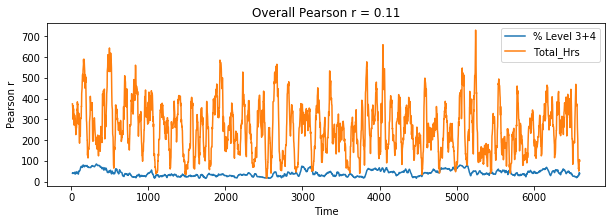

In [135]:
# compute rolling window synchrony
f,ax=plt.subplots(figsize=(10,3))
schools[schools['Total_Hrs']<=1393][['% Level 3+4', 'Total_Hrs']].rolling(window=30,center=True).mean().plot(ax=ax)
ax.set(xlabel='Time',ylabel='Pearson r')
ax.set(title=f"Overall Pearson r = {np.round(r,2)}");

In [28]:
# regression value between passing rate and instructional hours
stats.linregress(schools['% Level 3+4'], schools['Total_Hrs'])[2]

-0.004185665526533521

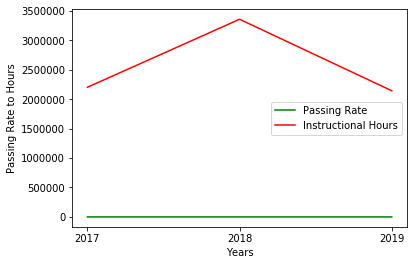

In [29]:
# plot total hours vs passing rate over 3 years
years = schools['Year'].unique().tolist()

testpr = schools.groupby('Year')['% Level 3+4'].mean().reset_index()['% Level 3+4']
artsth = schools.groupby('Year')['Total_Hrs'].sum().reset_index()['Total_Hrs']

plt.plot(years, testpr, color='green', label='Passing Rate')
plt.plot(years, artsth, color='red', label='Instructional Hours')

plt.legend(loc='best')
plt.xlabel('Years')
plt.ylabel('Passing Rate to Hours')
plt.xticks(years)

# display chart
plt.show()

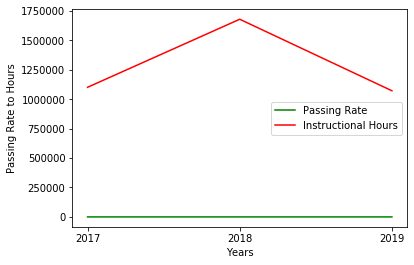

In [30]:
years = schools['Year'].unique().tolist()
test = 'Math'
cond = (schools['Test']==test)

mathpr = schools[cond].groupby('Year')['% Level 3+4'].mean().reset_index()['% Level 3+4']
mathth = schools[cond].groupby('Year')['Total_Hrs'].sum().reset_index()['Total_Hrs']

plt.plot(years, mathpr, color='green', label='Passing Rate')
plt.plot(years, mathth, color='red', label='Instructional Hours')

plt.legend(loc='best')
plt.xlabel('Years')
plt.ylabel('Passing Rate to Hours')
plt.xticks(years)

# display chart
plt.show()

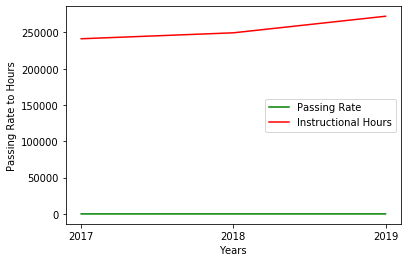

In [115]:
years = schools['Year'].unique().tolist()
test = 'ELA'
cond = ( (schools['Test']==test) & (schools['Total_Hrs'] <=1393) )

mathpr = schools[cond].groupby('Year')['% Level 3+4'].mean().reset_index()['% Level 3+4']
mathth = schools[cond].groupby('Year')['Total_Hrs'].sum().reset_index()['Total_Hrs']

plt.plot(years, mathpr, color='green', label='Passing Rate')
plt.plot(years, mathth, color='red', label='Instructional Hours')

plt.legend(loc='best')
plt.xlabel('Years')
plt.ylabel('Passing Rate to Hours')
plt.xticks(years)

plt.show()

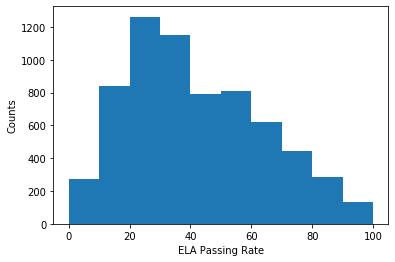

mean   = 41.773130995018256
median = 37.76643990929705
mode   = 0    33.333333
dtype: float64


In [38]:
# determine which measure of central tendency is most appropriate
test = 'ELA'
cond = schools['Test']==test
series = schools[cond]['% Level 3+4']
plt.hist(series)
plt.xlabel(f'{test} Passing Rate')
plt.ylabel('Counts')
plt.show()
# The median is the most appropriate measure because the data is (right) skewed.
print("mean   =", series.mean())
print("median =", series.median())
print("mode   =", series.mode())

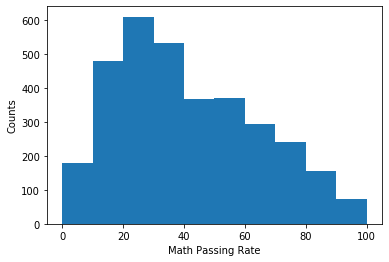

mean   = 41.20436864174246
median = 36.84210526315789
mode   = 0    33.333333
dtype: float64


In [39]:
# determine which measure of central tendency is most appropriate
test = 'Math'
cond = schools['Test']==test
series = schools[cond]['% Level 3+4']
plt.hist(series)
plt.xlabel(f'{test} Passing Rate')
plt.ylabel('Counts')
plt.show()
# The median is the most appropriate measure because the data is (right) skewed.
print("mean   =", series.mean())
print("median =", series.median())
print("mode   =", series.mode())

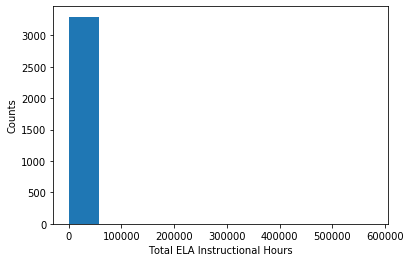

p-value = 3.0982316534424954e-46
The null hypothesis can be rejected


In [41]:
# determine if the instructional hours is normally distributed
test = 'ELA'
series = schools[schools['Test']==test]['Total_Hrs']
plt.hist(series)
plt.xlabel(f'Total {test} Instructional Hours')
plt.ylabel('Counts')
plt.show()

np.random.seed(42)
stat, p_value = stats.normaltest(series.sample(100))
print("p-value =", p_value)

# null hypothesis: sample comes from a normal distribution
alpha = 0.05
if p_value < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

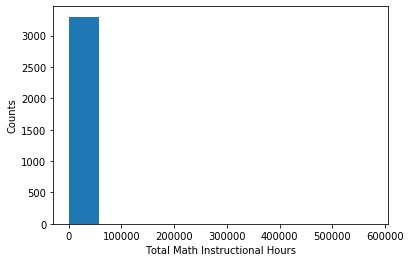

p-value = 1.4415852293926637e-47
The null hypothesis can be rejected


In [42]:
# determine if the instructional hours is normally distributed
test = 'Math'
series = schools[schools['Test']==test]['Total_Hrs']
plt.hist(series)
plt.xlabel(f'Total {test} Instructional Hours')
plt.ylabel('Counts')
plt.show()

#np.random.seed(0)
np.random.seed(42)
stat, p_value = stats.normaltest(series.sample(100))
print("p-value =", p_value)

# null hypothesis: sample comes from a normal distribution
alpha = 0.05
if p_value < alpha:
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

In [44]:
# Determine if there are any potential outliers in the total hours
cond = (schools['Test']=='ELA')
quartiles = schools['Total_Hrs'].quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of hours is: {lowerq}")
print(f"The upper quartile of hours is: {upperq}")
print(f"The interquartile range of hours is: {iqr}")
print(f"The the median of hours is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

outlier_cond = (schools['Total_Hrs'] < lower_bound) | (schools['Total_Hrs'] > upper_bound)
outlier_hours = schools.loc[outlier_cond]
print()
print(outlier_hours.shape)
outlier_hours.head(3)

The lower quartile of hours is: 13.0
The upper quartile of hours is: 565.0
The interquartile range of hours is: 552.0
The the median of hours is: 176.0 
Values below -815.0 could be outliers.
Values above 1393.0 could be outliers.

(692, 12)


,DBN,Year,Test,Number Tested,# Level 3+4,% Level 3+4,Dance,Music,Theater,Visual Arts,Total_Hrs,Art_Count
10,01M019,2019,ELA,82,46,56.097561,281.0,421.0,330.0,281.0,1936.0,4
11,01M019,2019,Math,80,38,47.500000,281.0,421.0,330.0,281.0,1936.0,4
102,01M378,2017,ELA,76,6,7.894737,0.0,0.0,60.0,810.0,1742.0,2


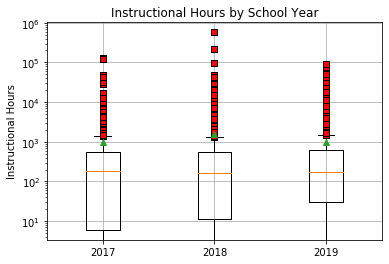

In [51]:
# Generate a box plot of the total hours across three years of interest
years = schools['Year'].unique()


# create list of `Total_Hrs` values for each school year
plots = [ schools[schools['Year'] == year]['Total_Hrs'] for year in years ]

# define a colors and styles for outliers
green_diamond = dict(markerfacecolor='g', marker='D')
red_square = dict(markerfacecolor='r', marker='s')

# create a box plot
plt.boxplot(plots, labels=years, showmeans=True, showfliers=True, flierprops=red_square)

# set title of box plot
plt.title('Instructional Hours by School Year')

# set vertical label
plt.ylabel('Instructional Hours')

# set vertical scale
plt.yscale('log')

# show grid
plt.grid()

# show chart
plt.show()

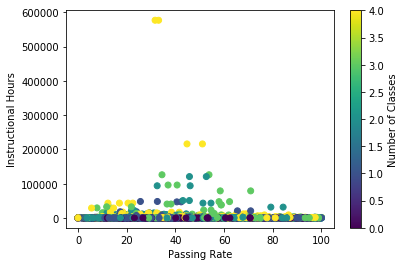

In [377]:
plt.scatter(schools['% Level 3+4'], schools['Total_Hrs'], c=schools['Art_Count']) #cmap='jet'
plt.colorbar(label="Number of Classes")
plt.xlabel("Passing Rate")
plt.ylabel("Instructional Hours")
plt.show()

(6612, 12)


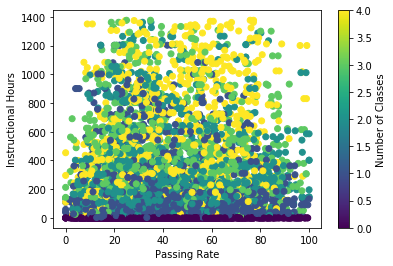

In [95]:
print(schools.shape)
test = schools[schools['Total_Hrs']< 1393]
plt.scatter(test['% Level 3+4'], test['Total_Hrs'], c=test['Art_Count']) #cmap='jet'
plt.colorbar(label="Number of Classes")
plt.xlabel("Passing Rate")
plt.ylabel("Instructional Hours")
plt.show()

In [52]:
test = 'Math'
stats.ttest_ind(schools['% Level 3+4'], schools['Total_Hrs'], equal_var=False)

Ttest_indResult(statistic=-7.731716200745989, pvalue=1.219043071865897e-14)

In [111]:
test = 'Math'
stats.ttest_ind(schools[schools['Test']==test]['% Level 3+4'], schools[schools['Test']==test]['Total_Hrs'], equal_var=False)

Ttest_indResult(statistic=-5.469301045928705, pvalue=4.8540005476644506e-08)

In [112]:
test = 'ELA'
stats.ttest_ind(schools[schools['Test']==test]['% Level 3+4'], schools[schools['Test']== test]['Total_Hrs'], equal_var=False)

Ttest_indResult(statistic=-5.469301045928705, pvalue=4.8540005476644506e-08)

In [53]:
test   = 'ELA'
cond1  = ( (schools['Test']==test) & (schools['Art_Count'] > 0) )
cond2  = ( (schools['Test']==test) & (schools['Art_Count'] == 0) )
stats.ttest_ind(schools[cond1]['% Level 3+4'], schools[cond2]['% Level 3+4'], equal_var=False)

Ttest_indResult(statistic=5.969012449202013, pvalue=3.1280445829123226e-09)

In [54]:
print(f"number of math schools {len(schools[(schools['Test']=='Math')]['DBN'].unique())}")
print(f"number of schools with art {len(schools[(schools['Test']=='Math')&(schools['Art_Count'] > 0)]['DBN'].unique())}")
print(f"number of schools with no art {len(schools[(schools['Test']=='Math')&(schools['Art_Count']==0)]['DBN'].unique())}")


number of math schools 1117
number of schools with art 1047
number of schools with no art 462


In [55]:
print(f"number of ela schools {len(schools[(schools['Test']=='ELA')]['DBN'].unique())}")
print(f"number of ela schools with art {len(schools[(schools['Test']=='ELA')&(schools['Art_Count'] > 0)]['DBN'].unique())}")
print(f"number of ela schools with no art {len(schools[(schools['Test']=='ELA')&(schools['Art_Count']==0)]['DBN'].unique())}")


number of ela schools 1117
number of ela schools with art 1047
number of ela schools with no art 461


In [120]:
# review the number of schools by `Test`
schools.groupby('Year')['Test'].apply(lambda x: x.value_counts()).reset_index().rename(columns={'level_1': 'Test', 'Test': 'Count'})

,Year,Test,Count
0,2017,Math,1092
1,2017,ELA,1092
2,2018,Math,1100
3,2018,ELA,1099
4,2019,Math,1115
5,2019,ELA,1114


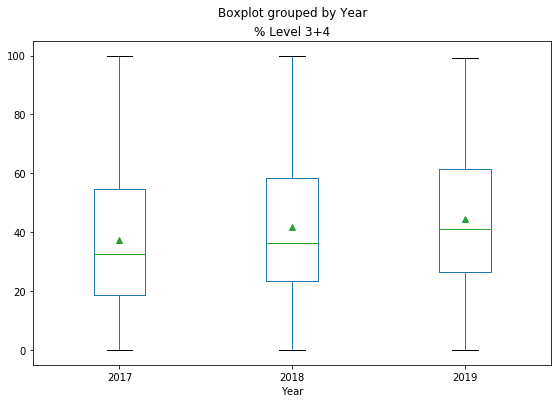

In [57]:
schools[schools['Test']=='Math'].boxplot('% Level 3+4', by='Year', figsize=(9,6), meanline=False, showmeans=True)
plt.grid(False)
plt.show()

In [58]:
test  = 'Math'
field = '% Level 3+4'

cond   = (schools['Test']==test)
d_cond = ( cond & (schools['Dance'] > 0) )
m_cond = ( cond & (schools['Music'] > 0) )
t_cond = ( cond & (schools['Theater'] > 0) )
v_cond = ( cond & (schools['Visual Arts'] > 0) )

ela_dance   = schools[d_cond][field]
ela_music   = schools[m_cond][field]
ela_theater = schools[t_cond][field]
ela_visual  = schools[v_cond][field]

# ANOVA
stats.f_oneway(ela_dance,
               ela_music,
               ela_theater,
               ela_visual)

F_onewayResult(statistic=5.201155952144854, pvalue=0.0013791554810370986)

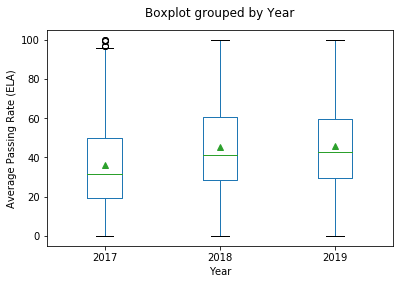

In [59]:
test   = 'ELA'
cond   = (schools['Test']==test)

schools[cond].boxplot('% Level 3+4', by = 'Year', meanline=False, showmeans=True)

plt.title('')
plt.ylabel(f'Average Passing Rate ({test})')
plt.grid(False)

plt.show()

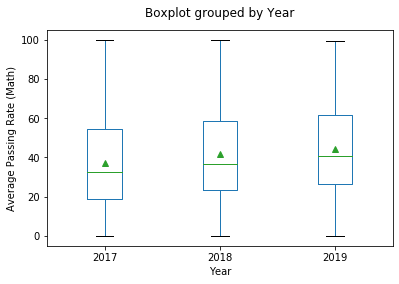

In [138]:
test    = 'Math'
cond    = (schools['Test']==test)
 
schools[cond].boxplot('% Level 3+4', by = 'Year', meanline=False, showmeans=True)

plt.title('')
plt.ylabel(f'Average Passing Rate ({test})')
plt.grid(False)

plt.show()

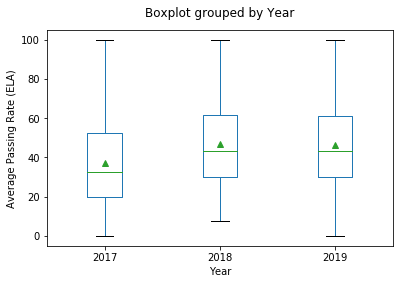

In [159]:
cond1 = ( (schools['Test']=='ELA') & (schools['Total_Hrs'] > 0) )

schools[cond1].boxplot('% Level 3+4', by = 'Year', meanline=False, showmeans=True)

plt.title('')
plt.ylabel(f'Average Passing Rate ({test})')
plt.grid(False)

plt.show()

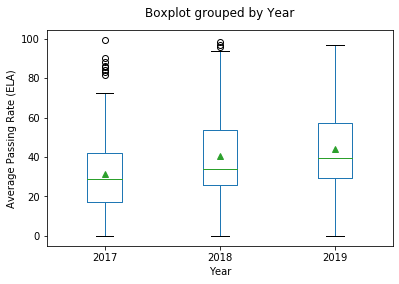

In [160]:
cond1 = ( (schools['Test']=='ELA') & (schools['Total_Hrs'] == 0) )

schools[cond1].boxplot('% Level 3+4', by = 'Year', meanline=False, showmeans=True)

plt.title('')
plt.ylabel(f'Average Passing Rate ({test})')
plt.grid(False)

plt.show()

In [60]:
# total number of schools from 2017-2019
ela_schools_cnt = len(schools[schools['Test']=='ELA']['DBN'].unique())
math_schools_cnt = len(schools[schools['Test']=='Math']['DBN'].unique())

In [61]:
# average passing rate from 2017-2019
ela_schools_pr = np.mean(schools[schools['Test']=='ELA']['% Level 3+4'])
math_schools_pr = np.mean(schools[schools['Test']=='Math']['% Level 3+4'])

print(ela_schools_pr)
print(math_schools_pr)

42.342237531260935
41.20436864174246


In [62]:
ela_d_cond = (schools['Test']=='ELA')&(schools['Dance'] > 0)
ela_m_cond = (schools['Test']=='ELA')&(schools['Music'] > 0)
ela_t_cond = (schools['Test']=='ELA')&(schools['Theater'] > 0)
ela_v_cond = (schools['Test']=='ELA')&(schools['Visual Arts'] > 0)

ela_dance_schools = len(schools[ela_d_cond]['DBN'].unique())
ela_music_schools = len(schools[ela_m_cond]['DBN'].unique())
ela_theater_schools = len(schools[ela_t_cond]['DBN'].unique())
ela_visual_schools = len(schools[ela_v_cond]['DBN'].unique())

ela_dance_pct = (ela_dance_schools/ela_schools_cnt)*100
ela_music_pct = (ela_music_schools/ela_schools_cnt)*100
ela_theater_pct = (ela_theater_schools/ela_schools_cnt)*100
ela_visual_pct = (ela_visual_schools/ela_schools_cnt)*100

ela_cond = (schools['Test']=='ELA')

ela_arts_hrs = np.sum(schools[ela_cond]['Total_Hrs'])
ela_dance_hrs = np.sum(schools[ela_cond]['Dance'])
ela_music_hrs = np.sum(schools[ela_cond]['Music'])
ela_theater_hrs = np.sum(schools[ela_cond]['Theater'])
ela_visual_hrs = np.sum(schools[ela_cond]['Visual Arts'])

ela_dh_pct = (ela_dance_hrs/ela_arts_hrs)*100
ela_mh_pct = (ela_music_hrs/ela_arts_hrs)*100
ela_th_pct = (ela_theater_hrs/ela_arts_hrs)*100
ela_vh_pct = (ela_visual_hrs/ela_arts_hrs)*100

ela_arts_cond = (schools['Test']=='ELA')&(schools['Art_Count'] > 0 )
ela_nart_cond = (schools['Test']=='ELA')&(schools['Art_Count'] == 0)
ela_arts_schools = len(schools[ela_arts_cond]['DBN'].unique())
ela_nart_schools = len(schools[ela_nart_cond]['DBN'].unique())

print(f'number of ELA schools {ela_schools_cnt}')
print()
print(f'{round(ela_dance_pct,2)} % of schools with dance provided by cultural organizations')
print(f'{round(ela_music_pct,2)} % of schools with music provided by cultural organizations')
print(f'{round(ela_theater_pct,2)} % of schools with theater provided by cultural organizations')
print(f'{round(ela_visual_pct,2)} % of schools with visual arts provided by cultural organizations')
print()
print(f'{round(ela_dh_pct,2)} % of hours of dance provided by cultural organizations')
print(f'{round(ela_mh_pct,2)} % of hours of music provided by cultural organizations')
print(f'{round(ela_th_pct,2)} % of hours of theater provided by cultural organizations')
print(f'{round(ela_vh_pct,2)} % of hours of visual arts provided by cultural organizations')
print()
print(f'{round(ela_arts_hrs,2)} total hours of arts provided by cultural organizations')
print()
pct_ela_arts = (ela_arts_schools/ela_schools_cnt)*100
pct_ela_nart = (ela_nart_schools/ela_schools_cnt)*100

print(f'{round(pct_ela_arts,2)} % of schools with art provided by cultural organizations')
print(f'{round(pct_ela_nart,2)} % of schools with no art provided')

number of ELA schools 1117

70.81 % of schools with dance provided by cultural organizations
69.56 % of schools with music provided by cultural organizations
63.12 % of schools with theater provided by cultural organizations
74.04 % of schools with visual arts provided by cultural organizations

15.76 % of hours of dance provided by cultural organizations
21.52 % of hours of music provided by cultural organizations
10.66 % of hours of theater provided by cultural organizations
20.53 % of hours of visual arts provided by cultural organizations

3850777.0 total hours of arts provided by cultural organizations

93.73 % of schools with art provided by cultural organizations
41.27 % of schools with no art provided


In [155]:
# average passing rate of taken art classes
ela_th_pr = np.mean(schools[(schools['Test']=='ELA')&(schools['Total_Hrs'] > 0)]['% Level 3+4'])
ela_d_pr = np.mean(schools[(schools['Test']=='ELA')&(schools['Dance'] > 0)]['% Level 3+4'])
ela_m_pr = np.mean(schools[(schools['Test']=='ELA')&(schools['Music'] > 0)]['% Level 3+4'])
ela_t_pr = np.mean(schools[(schools['Test']=='ELA')&(schools['Theater'] > 0)]['% Level 3+4'])
ela_v_pr = np.mean(schools[(schools['Test']=='ELA')&(schools['Visual Arts'] > 0)]['% Level 3+4'])
print('average passing rate of taken art classes')
print(f'avg for total hrs {ela_th_pr}')
print(f'avg for dance hrs {ela_d_pr}')
print(f'avg for music hrs {ela_m_pr}')
print(f'avg for theater hrs {ela_t_pr}')
print(f'avg for visual hrs {ela_v_pr}')

average passing rate of taken art classes
avg for total hrs 43.45930385327053
avg for dance hrs 45.083756634675666
avg for music hrs 43.98451298689534
avg for theater hrs 44.80771559016436
avg for visual hrs 42.762644111980656


In [156]:
# average passing rate of no art classes
ela_th_pr = np.mean(schools[(schools['Test']=='ELA')&(schools['Total_Hrs'] == 0)]['% Level 3+4'])
ela_d_pr = np.mean(schools[(schools['Test']=='ELA')&(schools['Dance'] == 0)]['% Level 3+4'])
ela_m_pr = np.mean(schools[(schools['Test']=='ELA')&(schools['Music'] == 0)]['% Level 3+4'])
ela_t_pr = np.mean(schools[(schools['Test']=='ELA')&(schools['Theater'] == 0)]['% Level 3+4'])
ela_v_pr = np.mean(schools[(schools['Test']=='ELA')&(schools['Visual Arts'] == 0)]['% Level 3+4'])
print('average passing rate of no art classes')
print(f'avg for total hrs {ela_th_pr}')
print(f'avg for dance hrs {ela_d_pr}')
print(f'avg for music hrs {ela_m_pr}')
print(f'avg for theater hrs {ela_t_pr}')
print(f'avg for visual hrs {ela_v_pr}')

average passing rate of no art classes
avg for total hrs 38.35998866785395
avg for dance hrs 39.5622937237765
avg for music hrs 40.93865418730412
avg for theater hrs 40.652486123221166
avg for visual hrs 41.91851060695115


In [157]:
# average passing rate of taken art classes
math_th_pr = np.mean(schools[(schools['Test']=='Math')&(schools['Total_Hrs'] > 0)]['% Level 3+4'])
math_d_pr = np.mean(schools[(schools['Test']=='Math')&(schools['Dance'] > 0)]['% Level 3+4'])
math_m_pr = np.mean(schools[(schools['Test']=='Math')&(schools['Music'] > 0)]['% Level 3+4'])
math_t_pr = np.mean(schools[(schools['Test']=='Math')&(schools['Theater'] > 0)]['% Level 3+4'])
math_v_pr = np.mean(schools[(schools['Test']=='Math')&(schools['Visual Arts'] > 0)]['% Level 3+4'])
print('average passing rate of taken art classes')
print(math_th_pr)
print(math_d_pr)
print(math_m_pr)
print(math_t_pr)
print(math_v_pr)

average passing rate of taken art classes
42.727142332569656
44.90620823803481
43.31523207328787
44.215371694408276
41.854019890461245


In [158]:
# average passing rate of no art classes
math_th_pr = np.mean(schools[(schools['Test']=='Math')&(schools['Total_Hrs'] == 0)]['% Level 3+4'])
math_d_pr = np.mean(schools[(schools['Test']=='Math')&(schools['Dance'] == 0)]['% Level 3+4'])
math_m_pr = np.mean(schools[(schools['Test']=='Math')&(schools['Music'] == 0)]['% Level 3+4'])
math_t_pr = np.mean(schools[(schools['Test']=='Math')&(schools['Theater'] == 0)]['% Level 3+4'])
math_v_pr = np.mean(schools[(schools['Test']=='Math')&(schools['Visual Arts'] == 0)]['% Level 3+4'])
print('average passing rate of no art classes')
print(math_th_pr)
print(math_d_pr)
print(math_m_pr)
print(math_t_pr)
print(math_v_pr)

schools[(schools['Test']=='Math')&(schools['Art_Count'] == 4)]['% Level 3+4'].head()

average passing rate of no art classes
35.79076134694242
37.455213992789105
39.40232547680773
39.142836240936155
40.55038112862086


1     44.927536
11    47.500000
13    31.730769
19    20.909091
37    78.409091
Name: % Level 3+4, dtype: float64

In [ ]:
# evaluate if statistically different between art and not art schools
x_val = schools[(schools['Test']=='Math')&(schools['Total_Hrs'] > 0)]['% Level 3+4']
y_val = schools[(schools['Test']=='Math')&(schools['Total_Hrs'] == 0)]['% Level 3+4']
stats.ttest_ind(x_val, y_val, equal_var=False)

In [ ]:
# evaluate if statistically different between art and not art schools
x_val = schools[(schools['Test']=='Math')&(schools['Visual Arts'] > 0)]['% Level 3+4']
y_val = schools[(schools['Test']=='Math')&(schools['Visual Arts'] == 0)]['% Level 3+4']
stats.ttest_ind(x_val, y_val, equal_var=False)

In [63]:
math_d_cond = (schools['Test']=='Math')&(schools['Dance'] > 0)
math_m_cond = (schools['Test']=='Math')&(schools['Music'] > 0)
math_t_cond = (schools['Test']=='Math')&(schools['Theater'] > 0)
math_v_cond = (schools['Test']=='Math')&(schools['Visual Arts'] > 0)

math_dance_schools = len(schools[math_d_cond]['DBN'].unique())
math_music_schools = len(schools[math_m_cond]['DBN'].unique())
math_theater_schools = len(schools[math_t_cond]['DBN'].unique())
math_visual_schools = len(schools[math_v_cond]['DBN'].unique())

math_dance_pct = (math_dance_schools/math_schools_cnt)*100
math_music_pct = (math_music_schools/math_schools_cnt)*100
math_theater_pct = (math_theater_schools/math_schools_cnt)*100
math_visual_pct = (math_visual_schools/math_schools_cnt)*100

math_cond = (schools['Test']=='Math')

math_arts_hrs = np.sum(schools[math_cond]['Total_Hrs'])
math_dance_hrs = np.sum(schools[math_cond]['Dance'])
math_music_hrs = np.sum(schools[math_cond]['Music'])
math_theater_hrs = np.sum(schools[math_cond]['Theater'])
math_visual_hrs = np.sum(schools[math_cond]['Visual Arts'])

math_dh_pct = (math_dance_hrs/math_arts_hrs)*100
math_mh_pct = (math_music_hrs/math_arts_hrs)*100
math_th_pct = (math_theater_hrs/math_arts_hrs)*100
math_vh_pct = (math_visual_hrs/math_arts_hrs)*100

math_arts_cond = (schools['Test']=='Math')&(schools['Art_Count'] > 0 )
math_nart_cond = (schools['Test']=='Math')&(schools['Art_Count'] == 0)
math_arts_schools = len(schools[math_arts_cond]['DBN'].unique())
math_nart_schools = len(schools[math_nart_cond]['DBN'].unique())

print(f'number of Math schools {math_schools_cnt}')
print()
print(f'{round(math_dance_pct,2)} % of schools with dance provided by cultural organizations')
print(f'{round(math_music_pct,2)} % of schools with music provided by cultural organizations')
print(f'{round(math_theater_pct,2)} % of schools with theater provided by cultural organizations')
print(f'{round(math_visual_pct,2)} % of schools with visual arts provided by cultural organizations')
print()
print(f'{round(math_dh_pct,2)} % of hours of dance provided by cultural organizations')
print(f'{round(math_mh_pct,2)} % of hours of music provided by cultural organizations')
print(f'{round(math_th_pct,2)} % of hours of theater provided by cultural organizations')
print(f'{round(math_vh_pct,2)} % of hours of visual arts provided by cultural organizations')
print()
print(f'{round(math_arts_hrs,2)} total hours of arts provided by cultural organizations')
print()
pct_math_arts = (math_arts_schools/math_schools_cnt)*100
pct_math_nart = (math_nart_schools/math_schools_cnt)*100

print(f'{round(pct_math_arts,2)} % of schools with art provided by cultural organizations')
print(f'{round(pct_math_nart,2)} % of schools with no art provided')

number of Math schools 1117

70.81 % of schools with dance provided by cultural organizations
69.56 % of schools with music provided by cultural organizations
63.12 % of schools with theater provided by cultural organizations
74.04 % of schools with visual arts provided by cultural organizations

15.76 % of hours of dance provided by cultural organizations
21.52 % of hours of music provided by cultural organizations
10.66 % of hours of theater provided by cultural organizations
20.53 % of hours of visual arts provided by cultural organizations

3850596.0 total hours of arts provided by cultural organizations

93.73 % of schools with art provided by cultural organizations
41.36 % of schools with no art provided


In [77]:
arts_summary = schools[schools.columns.tolist()[1:2]+schools.columns.tolist()[5:]]

arts_summary = arts_summary.rename(columns={ 
    '% Level 3+4': 'Avg_Passed',
    'Visual Arts': 'Visual_Arts'
})

print(arts_summary.shape)
arts_summary.head()

(6612, 8)


,Year,Avg_Passed,Dance,Music,Theater,Visual_Arts,Total_Hrs,Art_Count
0,2017,35.820896,72.0,112.0,35.0,20.0,304.0,4
1,2017,44.927536,72.0,112.0,35.0,20.0,304.0,4
2,2018,67.164179,8.0,150.0,48.0,0.0,261.0,3
3,2018,58.208955,8.0,150.0,48.0,0.0,261.0,3
4,2019,60.000000,0.0,180.0,80.0,0.0,346.0,2


In [81]:
group1_ela = schools[(schools['Test']=='ELA')&(schools['Art_Count'] == 0)]['% Level 3+4']
group2_ela = schools[(schools['Test']=='ELA')&(schools['Art_Count'] == 1)]['% Level 3+4']
group3_ela = schools[(schools['Test']=='ELA')&(schools['Art_Count'] == 2)]['% Level 3+4']
group4_ela = schools[(schools['Test']=='ELA')&(schools['Art_Count'] == 3)]['% Level 3+4']
group5_ela = schools[(schools['Test']=='ELA')&(schools['Art_Count'] == 4)]['% Level 3+4']

# Perform the ANOVA
stats.f_oneway(group1_ela, group2_ela, group3_ela, group4_ela, group5_ela)

F_onewayResult(statistic=11.646481668285695, pvalue=2.1596228045547386e-09)

In [82]:
group1_math = schools[(schools['Test']=='Math')&(schools['Art_Count'] == 0)]['% Level 3+4']
group2_math = schools[(schools['Test']=='Math')&(schools['Art_Count'] == 1)]['% Level 3+4']
group3_math = schools[(schools['Test']=='Math')&(schools['Art_Count'] == 2)]['% Level 3+4']
group4_math = schools[(schools['Test']=='Math')&(schools['Art_Count'] == 3)]['% Level 3+4']
group5_math = schools[(schools['Test']=='Math')&(schools['Art_Count'] == 4)]['% Level 3+4']

# Perform the ANOVA
stats.f_oneway(group1_math, group2_math, group3_math, group4_math, group5_math)

F_onewayResult(statistic=17.234413700013775, pvalue=5.3165539705920124e-14)

In [83]:
# Welch T-test
stats.ttest_ind(group3_math, group3_ela)

Ttest_indResult(statistic=-0.541758509694757, pvalue=0.5880729714581735)

In [84]:
grades_classes = pd.DataFrame()

grades_classes['Number_Tested'] = schools.groupby(['Test','Year'])['Number Tested'].mean()
grades_classes['Pct_Passing'] = schools.groupby(['Test','Year'])['% Level 3+4'].mean()
grades_classes['Avg_No_Classes'] = schools.groupby(['Test','Year'])['Art_Count'].mean()
grades_classes['Avg_Hours'] = schools.groupby(['Test','Year'])['Total_Hrs'].mean()

grades_classes.reset_index(inplace=True)

grades_classes

,Test,Year,Number_Tested,Pct_Passing,Avg_No_Classes,Avg_Hours
0,ELA,2017,236.966117,35.893716,1.847070,1008.178571
1,ELA,2018,233.501365,45.295442,1.855323,1527.374886
2,ELA,2019,227.669659,45.749971,1.915619,961.634650
3,Math,2017,241.857143,37.316614,1.847070,1008.010989
4,Math,2018,237.119091,41.688503,1.853636,1525.986364
5,Math,2019,231.598206,44.534306,1.913901,960.773991


# TEST

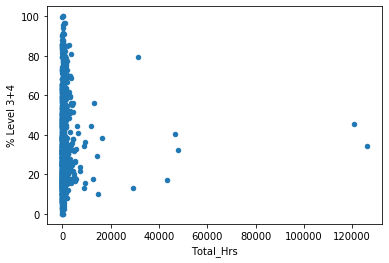

In [165]:
test = 'ELA'
year = 2017
cond = ( (schools['Year'] == year) & (schools['Test'] == test) )

#plt.scatter(schools[cond]['% Level 3+4'], schools[cond]['Total_Hrs'], label = str(year))
schools[cond].plot(x='Total_Hrs', y='% Level 3+4', kind='scatter')
#plt.xlim(0, 100)
plt.show()

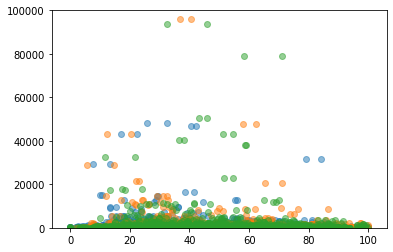

In [85]:

year = 2017
cond1 = ( (schools['Year'] == year) & (schools['Total_Hrs'] > 0) )
cond2 = ( (schools['Year'] == year) & (schools['Total_Hrs'] == 0) )
plt.scatter(schools[cond1]['% Level 3+4'], schools[cond1]['Total_Hrs'], label = str(year), alpha=0.5)

year = 2018
cond1 = ( (schools['Year'] == year) & (schools['Total_Hrs'] > 0) )
cond2 = ( (schools['Year'] == year) & (schools['Total_Hrs'] == 0) )
plt.scatter(schools[cond1]['% Level 3+4'], schools[cond1]['Total_Hrs'], label = str(year), alpha=0.5)

year = 2019
cond1 = ( (schools['Year'] == year) & (schools['Total_Hrs'] > 0) )
cond2 = ( (schools['Year'] == year) & (schools['Total_Hrs'] == 0) )
plt.scatter(schools[cond1]['% Level 3+4'], schools[cond1]['Total_Hrs'], label = str(year), alpha=0.5)

plt.ylim(0, 100000)
plt.show()

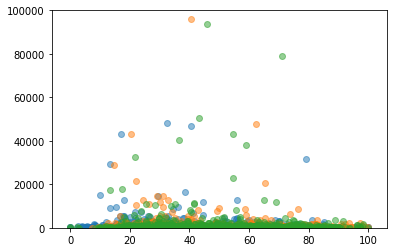

In [395]:
test = 'ELA'
year = 2017
cond1 = ( (schools['Year'] == year) & (schools['Test'] == test) & (schools['Total_Hrs'] > 0) )
cond2 = ( (schools['Year'] == year) & (schools['Test'] == test) & (schools['Total_Hrs'] == 0) )
plt.scatter(schools[cond1]['% Level 3+4'], schools[cond1]['Total_Hrs'], label = str(year), alpha=0.5)
#schools[cond].plot(x='% Level 3+4', y='Total_Hrs', kind='scatter')

test = 'ELA'
year = 2018
cond1 = ( (schools['Year'] == year) & (schools['Test'] == test) & (schools['Total_Hrs'] > 0) )
cond2 = ( (schools['Year'] == year) & (schools['Test'] == test) & (schools['Total_Hrs'] == 0) )
plt.scatter(schools[cond1]['% Level 3+4'], schools[cond1]['Total_Hrs'], label = str(year), alpha=0.5)
#schools[cond].plot(x='% Level 3+4', y='Total_Hrs', kind='scatter')

test = 'ELA'
year = 2019
cond1 = ( (schools['Year'] == year) & (schools['Test'] == test) & (schools['Total_Hrs'] > 0) )
cond2 = ( (schools['Year'] == year) & (schools['Test'] == test) & (schools['Total_Hrs'] == 0) )
plt.scatter(schools[cond1]['% Level 3+4'], schools[cond1]['Total_Hrs'], label = str(year), alpha=0.5)
#schools[cond].plot(x='% Level 3+4', y='Total_Hrs', kind='scatter')

plt.ylim(0, 100000)
plt.show()

In [388]:
test = 'ELA'
cond0 = schools[(schools['Test']==test)&(schools['Art_Count'] == 0)]
cond1 = schools[(schools['Test']==test)&(schools['Art_Count'] == 1)]
cond2 = schools[(schools['Test']==test)&(schools['Art_Count'] == 2)]
cond3 = schools[(schools['Test']==test)&(schools['Art_Count'] == 3)]
cond4 = schools[(schools['Test']==test)&(schools['Art_Count'] == 4)]

stats.f_oneway(cond0['% Level 3+4'],
               cond1['% Level 3+4'],
               cond2['% Level 3+4'],
               cond3['% Level 3+4'],
               cond4['% Level 3+4'])

F_onewayResult(statistic=11.646481668285695, pvalue=2.1596228045547386e-09)

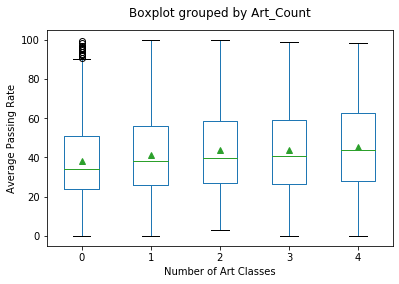

In [391]:
ela_counts = cond0.append(
               [cond1, 
               cond2,
               cond3,
               cond4])
ela_counts.boxplot('% Level 3+4', by = 'Art_Count', meanline = False, showmeans = True)
plt.title('')
plt.xlabel('Number of Art Classes')
plt.ylabel('Average Passing Rate')
plt.grid(False)
plt.show()

In [207]:
test = 'Math'
cond0 = schools[(schools['Test']==test)&(schools['Art_Count'] == 0)]
cond1 = schools[(schools['Test']==test)&(schools['Art_Count'] == 1)]
cond2 = schools[(schools['Test']==test)&(schools['Art_Count'] == 2)]
cond3 = schools[(schools['Test']==test)&(schools['Art_Count'] == 3)]
cond4 = schools[(schools['Test']==test)&(schools['Art_Count'] == 4)]

stats.f_oneway(cond0['% Level 3+4'],
               cond1['% Level 3+4'],
               cond2['% Level 3+4'],
               cond3['% Level 3+4'],
               cond4['% Level 3+4'])

F_onewayResult(statistic=19.737905539226315, pvalue=4.516621926094467e-16)

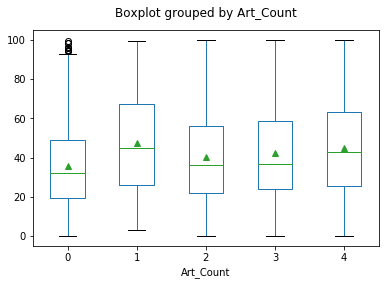

In [208]:
math_counts = cond0.append(
               [cond1, 
               cond2,
               cond3,
               cond4])
math_counts.boxplot('Total_Hrs', by = 'Art_Count', meanline = False, showmeans = True)
plt.title('')
plt.grid(False)
plt.show()